In [253]:
from tokenize import String
from textblob import TextBlob as tb
import pandas as pd
import re
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer as Sia
from gensim.parsing.preprocessing import remove_stopwords
from pathlib import Path
from collections import defaultdict
import numpy as np
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS 
import matplotlib.pyplot as plt
import hvplot.pandas 
import hvplot.dask  
import tweepy
client = tweepy.Client('AAAAAAAAAAAAAAAAAAAAAHdLbQEAAAAA2PhQivNYM%2BJ%2FaUQ1ZzOeiFchHG8%3DKFLPQdtclWWlwoyZShoLdm4QXAmPbuVyw3oAfMJNclQZCbalHU')

%matplotlib inline

nltk.download('vader_lexicon')
nltk.download('words')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\gunin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\gunin\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

## Data

In [128]:
sia = Sia()
emoji_raw = pd.read_html("https://kt.ijs.si/data/Emoji_sentiment_ranking")
emoji_lookup_df = emoji_raw[0][['Char', 'Sentiment score[-1...+1]']]
emoji_lookup_df.rename(columns={'Sentiment score[-1...+1]': 'sentiment_score'}, inplace = True)


csv_path = Path("stockerbot-export.csv")
tweet_df = pd.read_csv(csv_path, error_bad_lines=False)



C:\Users\gunin\anaconda3\envs\pyvizenv\lib\site-packages\pandas\core\frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\gunin\anaconda3\envs\pyvizenv\lib\site-packages\IPython\core\interactiveshell.py:3457: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 731: expected 8 fields, saw 13\nSkipping line 2836: expected 8 fields, saw 15\nSkipping line 3058: expected 8 fields, saw 12\nSkipping line 3113: expected 8 fields, saw 12\nSkipping line 3194: expected 8 fields, saw 17\nSkipping line 3205: expected 8 fields, saw 17\nSkipping line 3255: expected 8 fields, saw 17\nSkipping line 3520: expected 8 fields, saw 17\nSkipping line 4078: expected 8 field

## Funnction definitions

In [180]:
def clean_text(input_str: str) -> str:
    input_str = input_str.lower()
    input_str = re.sub("[^A-Za-z0-9]"," ",input_str)
    input_str = re.sub(r'^https?:\/\/.*[\r\n]*', '', input_str, flags=re.MULTILINE)
    input_str = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', input_str)
    input_str = re.sub(r"www.\S+",'',input_str)
    input_str = remove_stopwords(input_str)
    return input_str

def get_tb_score(text: str) -> float:
    return tb(text).sentiment[0]

def get_nltk_score(text: str) -> float:
    return sia.polarity_scores(text)['compound']

def build_sentiment_df(tweet_dataframe, target_column):
    # getting the corresponding data in lists
    raw_tweets = tweet_dataframe[target_column].tolist()
    cleaned_tweets = [clean_text(i) for i in raw_tweets]
    tb_subjectivity = [tb(i).sentiment[1] for i in cleaned_tweets]
    nltk_polarity = [sia.polarity_scores(i)['compound'] for i in cleaned_tweets]
    
    # building the dataframe
    final_df = pd.DataFrame()
    final_df['tweets'] = raw_tweets
    final_df['cleaned_tweets'] = cleaned_tweets
    final_df['textblob_subjectivity'] = tb_subjectivity
    final_df['nltk_polarity'] = nltk_polarity

    final_df = final_df[final_df['tweets'].apply(lambda x: len(x.split(',')) < 280)]
    final_df = final_df.drop_duplicates()
    final_df = final_df[final_df['tweets'].str.contains("RT ") == False] 

    return final_df

def get_emoji_count(tweet_df):
    emoji_count = defaultdict(int)
    for i in tweet_df['tweets']:
        for emoji in re.findall(u'[\U0001f300-\U0001f650]', i):
            emoji_count[emoji] += 1

    return emoji_count


In [194]:
refined_tweet_df = build_sentiment_df(tweet_df, 'text')
emoji_data = get_emoji_count(refined_tweet_df)


In [195]:
sort_count = sorted(emoji_data.items(), key=lambda x: x[1], reverse=True)
sort_count

[('💰', 420),
 ('🙌', 262),
 ('😍', 261),
 ('💸', 256),
 ('😊', 223),
 ('💎', 216),
 ('📈', 165),
 ('📉', 54),
 ('🔥', 54),
 ('🌕', 43),
 ('📢', 34),
 ('🎉', 32),
 ('💵', 21),
 ('👀', 18),
 ('👍', 18),
 ('🌑', 18),
 ('😂', 18),
 ('👇', 15),
 ('😎', 12),
 ('📣', 12),
 ('🔹', 11),
 ('💕', 11),
 ('🏻', 10),
 ('😉', 9),
 ('💼', 7),
 ('💳', 7),
 ('🕘', 6),
 ('🔔', 6),
 ('💪', 5),
 ('👈', 5),
 ('🙄', 5),
 ('😘', 5),
 ('🔰', 5),
 ('💲', 4),
 ('🍾', 4),
 ('💯', 4),
 ('🏼', 4),
 ('🐂', 4),
 ('😋', 4),
 ('🏽', 3),
 ('📊', 3),
 ('😀', 3),
 ('😳', 3),
 ('💥', 3),
 ('😜', 3),
 ('🔌', 2),
 ('🗣', 2),
 ('🎼', 2),
 ('🙏', 2),
 ('🕵', 2),
 ('😅', 2),
 ('👁', 2),
 ('😈', 2),
 ('👽', 2),
 ('🔐', 2),
 ('💩', 2),
 ('👉', 2),
 ('🌊', 2),
 ('👏', 2),
 ('😁', 2),
 ('🖐', 2),
 ('😝', 2),
 ('👙', 2),
 ('💜', 2),
 ('🌭', 2),
 ('😱', 2),
 ('🍑', 2),
 ('😄', 2),
 ('🗡', 1),
 ('🍪', 1),
 ('🐔', 1),
 ('😭', 1),
 ('🍕', 1),
 ('🍺', 1),
 ('👟', 1),
 ('💞', 1),
 ('💘', 1),
 ('🙆', 1),
 ('📅', 1),
 ('🎲', 1),
 ('📡', 1),
 ('🐻', 1),
 ('😆', 1),
 ('🔝', 1),
 ('🔍', 1),
 ('💛', 1),
 ('🎊', 1),
 ('😨', 1),
 (

In [196]:
emoji_sample = sort_count[0:20]
q = emoji_sample[6][0]

In [197]:
print(emoji_lookup_df.loc[emoji_lookup_df.Char == q, 'sentiment_score'])

Series([], Name: sentiment_score, dtype: float64)


In [198]:
def group_emojis(counts):
    pos_lst=[]
    neut_lst = []
    neg_lst=[]
    for emoji in counts:
        score = emoji_lookup_df.loc[emoji_lookup_df.Char == emoji[0], 'sentiment_score']
        if score.values < 0:
            neg_lst.append(emoji)
        elif score.values > 0 and score.values < 0.3:
            neut_lst.append(emoji)
        else:
            pos_lst.append(emoji)
    return pos_lst[0:5], neut_lst[0:5], neg_lst[0:5]

In [199]:
group_emojis(sort_count)

C:\Users\gunin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  import sys
C:\Users\gunin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if __name__ == '__main__':


([('🙌', 262), ('😍', 261), ('😊', 223), ('💎', 216), ('📈', 165)],
 [('💰', 420), ('💸', 256), ('🔥', 54), ('👀', 18), ('😂', 18)],
 [('🔌', 2), ('💩', 2), ('😭', 1), ('😨', 1), ('😲', 1)])

In [200]:
ge1 = group_emojis(sort_count)[0]
ge2 = group_emojis(sort_count)[1]
ge3 = group_emojis(sort_count)[2]

pos_sample_df = pd.DataFrame(ge1)
neut_sample_df = pd.DataFrame(ge2)
neg_sample_df = pd.DataFrame(ge3)

C:\Users\gunin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  import sys
C:\Users\gunin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if __name__ == '__main__':


In [201]:
pos_sample_df

,0,1
0,🙌,262
1,😍,261
2,😊,223
3,💎,216
4,📈,165


In [202]:
neut_sample_df

,0,1
0,💰,420
1,💸,256
2,🔥,54
3,👀,18
4,😂,18


In [203]:
neg_sample_df

,0,1
0,🔌,2
1,💩,2
2,😭,1
3,😨,1
4,😲,1


In [204]:
def get_samples(tweet_dataframe):
    sorted_df = tweet_dataframe.sort_values(by='nltk_polarity', ascending=False)
    top20 = sorted_df['cleaned_tweets'].head(50)
    bottom20 = sorted_df['cleaned_tweets'].tail(50)
    return {'positive sample': list(top20.values), 'negative sample': list(bottom20.values)}

samples = get_samples(build_sentiment_df(tweet_df, 'text'))
words = set(nltk.corpus.words.words())


for sample in samples['positive sample']:
    sample = " ".join(w for w in nltk.wordpunct_tokenize(sample) if w.lower() in words or not w.isalpha())
for sample in samples['negative sample']:
    sample = " ".join(w for w in nltk.wordpunct_tokenize(sample) if w.lower() in words or not w.isalpha())

# dont need this line of code
samples['negative sample'].pop(48)

samples['positive sample'] = " ".join(sample for sample in samples['positive sample'])
samples['negative sample'] = " ".join(sample for sample in samples['negative sample'])

samples


{'positive sample': 'yay got unbelievable sold 11th win row today congrats class amp coach brandonvanzee love buy high https t xxclmq8k4h freedom hustle work earn income wealth rich success millionaire goodlife future boss https t n0djjrdtlp project strong team lot work great future support recommend friends https t 45wywnomlp absolutely love app join robinhoodapp ll stock like aapl f s free sure https t 4mpjiervcs free share stock good pass refer friend 1 250 chance fb aapl jpm 1 200 chance https t otwggtq0j2 btc x great news gs new ceo embracing crypto good stuff coming ma driving momentum good guys winning best buy best buy today s cg episode takes look longevity big box retailer s success bby https t 5jwumr6ery good morning adding aryc great investment opportunity t miss beautiful run https t ph0ikrnkzh join robinhoodapp ll stock like aapl f s free sure use link free stock https t aqrlxnjnjp day day point spy spx qqq better safe amp risk free overly exposed right good luck traders 

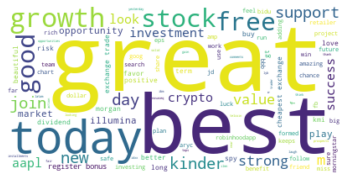

In [205]:
stopwords = set(STOPWORDS)
# add asset names and tickers to this list
stopwords.update(['https', 'http', 't', 's', 'll', 'mon'])

pos_wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(samples['positive sample'])
plt.imshow(pos_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

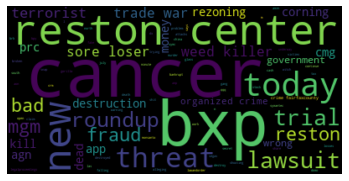

In [206]:
neg_wordcloud = WordCloud(stopwords=stopwords).generate(samples['negative sample'])
plt.imshow(neg_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [229]:
refined_tweet_df.hvplot.scatter(x='nltk_polarity', y='textblob_subjectivity')

:Scatter   [nltk_polarity]   (textblob_subjectivity)

In [210]:
refined_tweet_df[['nltk_polarity', 'textblob_subjectivity']].corr()

,nltk_polarity,textblob_subjectivity
nltk_polarity,1.000000,0.198259
textblob_subjectivity,0.198259,1.000000


In [214]:
vix_data_path = Path("vix_data.csv")
vix_data_df = pd.read_csv(vix_data_path)
vix_data_df.head()

,time,NEGATIVE,POSITIVE,pct,nltk_polarity
0,2022-04-04 02:00:00+00:00,70,47,0.401709,-0.004726
1,2022-04-04 03:00:00+00:00,47,50,0.515464,0.008890
2,2022-04-04 04:00:00+00:00,41,67,0.620370,0.119624
3,2022-04-04 05:00:00+00:00,27,44,0.619718,0.199152
4,2022-04-04 06:00:00+00:00,43,35,0.448718,0.087353


In [222]:
vix_path = Path("vix.csv")
vix_df = pd.read_csv(vix_path, skiprows=1)
vix_df.head()

,Date Time,Open,High,Low,Close,Change,Volume,Open Interest
0,4/04/2022 0:00,22.30,22.33,22.15,22.20,-0.10,87.0,NaN
1,4/04/2022 1:00,22.20,22.26,22.10,22.25,0.05,255.0,NaN
2,4/04/2022 2:00,22.20,22.57,22.15,22.45,0.20,537.0,NaN
3,4/04/2022 3:00,22.40,22.55,22.30,22.35,-0.10,403.0,NaN
4,4/04/2022 4:00,22.35,22.35,22.13,22.15,-0.20,378.0,NaN


In [223]:
vix_data = pd.concat([vix_data_df, vix_df['Change']], axis='columns', join='inner')
vix_data.head()

,time,NEGATIVE,POSITIVE,pct,nltk_polarity,Change
0,2022-04-04 02:00:00+00:00,70,47,0.401709,-0.004726,-0.10
1,2022-04-04 03:00:00+00:00,47,50,0.515464,0.008890,0.05
2,2022-04-04 04:00:00+00:00,41,67,0.620370,0.119624,0.20
3,2022-04-04 05:00:00+00:00,27,44,0.619718,0.199152,-0.10
4,2022-04-04 06:00:00+00:00,43,35,0.448718,0.087353,-0.20


In [225]:
vix_data.corr()

,NEGATIVE,POSITIVE,pct,nltk_polarity,Change
NEGATIVE,1.000000,0.585435,-0.452116,-0.297246,-0.091646
POSITIVE,0.585435,1.000000,0.425471,-0.209534,-0.026454
pct,-0.452116,0.425471,1.000000,0.143937,0.088663
nltk_polarity,-0.297246,-0.209534,0.143937,1.000000,-0.221765
Change,-0.091646,-0.026454,0.088663,-0.221765,1.000000


In [232]:
vix_data.hvplot.scatter(
    x='nltk_polarity',
    y='Change'
)

:Scatter   [nltk_polarity]   (Change)

In [258]:
def tweets(start_time, end_time, iterations, query):
    datelist = pd.date_range(start_time, end_time, periods=iterations).tolist()
    tweets=[]
    date=[]
    prob=[]
    sentim=[]
    a=0
    for time in datelist:
        if a>1:
            #Fetching Tweets
            response = client.search_recent_tweets(query, max_results=100, start_time=start, end_time=time, tweet_fields=["created_at"])
            response.data
            if type(response.data) != type(None):
                #Data Cleaning
                for i in response.data:
                    tw=i
                    tw=str(i)
                    tw=tw.lower()
                    tw=tw.split()
                    tw=' '.join(word for word in tw)
                    #Sentiment analysis
                    if len(tw) > 0:                        
                        tweets.append(tw)
                        date.append(i.created_at)                        
        start=time
        a=a+1
        
    tweet_df=pd.DataFrame({'time':date, 'tweet':tweets})
    tweet_df=tweet_df.sort_values(by='time', ascending=True).set_index('time')
    return tweet_df

In [259]:
btc_tweets = tweets('2022-04-05', '2022-04-11', 100, 'btc OR bitcoin OR crypto -is:retweet lang:en')

In [260]:
btc_tweets

,tweet
time,
2022-04-05 02:54:18+00:00,follow me!!! #bitcoin #btc #blockchain #bts #b...
2022-04-05 02:54:19+00:00,@dracoo_master i believe this is a faithful pr...
2022-04-05 02:54:19+00:00,"when $xrp moves, it turns the entire crypto sp..."
2022-04-05 02:54:19+00:00,"rt @mrbitcoinbaron: thank you for a 1,000 foll..."
2022-04-05 02:54:19+00:00,xrp is getting ready to fly to the moon! #xrp ...
...,...
2022-04-10 23:59:59+00:00,📈 ethusd buy signal now (severity: 3) #eth #cr...
2022-04-10 23:59:59+00:00,@crypto_whaler @drfamilyallergy @terareum @mil...
2022-04-10 23:59:59+00:00,rt @gemhostofficial: $2000 | 28 jy | honda cbr...


In [262]:
btc_data = build_sentiment_df(btc_tweets, 'tweet')

In [263]:
btc_data.head()

,tweets,cleaned_tweets,textblob_subjectivity,nltk_polarity
0,follow me!!! #bitcoin #btc #blockchain #bts #b...,follow bitcoin btc blockchain bts btsarmy btsx...,0.0000,0.0000
1,@dracoo_master i believe this is a faithful pr...,dracoo master believe faithful project project...,0.2125,0.9118
2,"when $xrp moves, it turns the entire crypto sp...",xrp moves turns entire crypto space dust xrp r...,0.6250,0.0000
3,"rt @mrbitcoinbaron: thank you for a 1,000 foll...",rt mrbitcoinbaron thank 1 000 followers love b...,0.6000,0.7717
4,xrp is getting ready to fly to the moon! #xrp ...,xrp getting ready fly moon xrp ripple bitcoin ...,0.7000,0.3612


In [265]:
btc_emoji = group_emojis(sorted(get_emoji_count(btc_data).items(), key=lambda x: x[1], reverse=True)) 

C:\Users\gunin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  import sys
C:\Users\gunin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if __name__ == '__main__':


In [266]:
btc_emoji

([('💎', 211), ('👉', 150), ('🔴', 136), ('🎁', 135), ('🏆', 113)],
 [('🔥', 1040), ('👇', 248), ('💥', 201), ('💰', 148), ('💸', 137)],
 [('💧', 74), ('📌', 55), ('🐑', 15), ('😭', 11), ('💀', 8)])

In [280]:
btc_ge1 = btc_emoji[0]
btc_ge2 = btc_emoji[1]
btc_ge3 = btc_emoji[2]

btc_pos_sample_df = pd.DataFrame(btc_ge1)
btc_neut_sample_df = pd.DataFrame(btc_ge2)
btc_neg_sample_df = pd.DataFrame(btc_ge3)

In [ ]:
btc_samples = get_samples(btc_data)
btc_samples['positive sample'] = " ".join(sample for sample in btc_samples['positive sample'])
btc_samples['negative sample'] = " ".join(sample for sample in btc_samples['negative sample'])
btc_samples

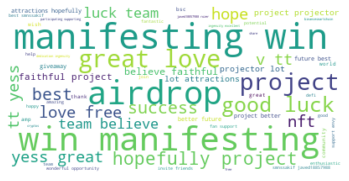

In [333]:
stopwords.update(['https', 'http', 't', 's', 'll', 'mon', 'bitcoin', 'btc', 'crypto', 'cryptocurrency', 'tsla', 'tesla', 'gamestop', 'gt', 'elonmusk', 'rt', 'amc', 'gme', 'eth', 'ethereum', 'missed', 'doge', 'dogecoin', 'ada', 'cardano', 'xrp', 'bnb', 'ripple', 'binance'])

btc_pos_wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(btc_samples['positive sample'])
plt.imshow(btc_pos_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

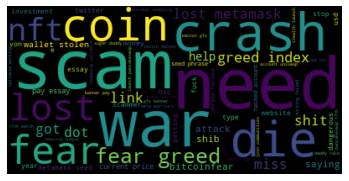

In [336]:
btc_neg_wordcloud = WordCloud(stopwords=stopwords).generate(btc_samples['negative sample'])
plt.imshow(btc_neg_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
eth_tweets = tweets('2022-04-05', '2022-04-11', 100, 'eth OR ethereum OR crypto -is:retweet lang:en')
eth_data = build_sentiment_df(eth_tweets, 'tweet')
eth_data.head()

In [ ]:
eth_emoji = group_emojis(sorted(get_emoji_count(eth_data).items(), key=lambda x: x[1], reverse=True))
eth_emoji 

C:\Users\gunin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  import sys
C:\Users\gunin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if __name__ == '__main__':


([('🎁', 706), ('🏆', 604), ('🎉', 462), ('💎', 216), ('👉', 150)],
 [('🔥', 1005), ('👇', 298), ('💰', 236), ('💥', 169), ('💸', 110)],
 [('📌', 258), ('💀', 17), ('😭', 8), ('💧', 4), ('🐸', 4)])

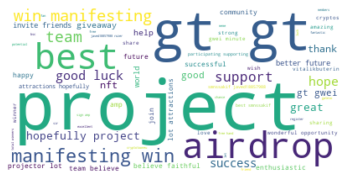

In [309]:
eth_samples = get_samples(eth_data)
eth_samples['positive sample'] = " ".join(sample for sample in eth_samples['positive sample'])
eth_samples['negative sample'] = " ".join(sample for sample in eth_samples['negative sample'])

eth_pos_wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(eth_samples['positive sample'])
plt.imshow(eth_pos_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

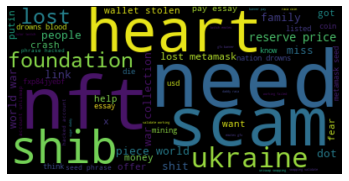

In [337]:
eth_neg_wordcloud = WordCloud(stopwords=stopwords).generate(eth_samples['negative sample'])
plt.imshow(eth_neg_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [299]:
ada_tweets = tweets('2022-04-05', '2022-04-11', 100, 'ada OR cardano OR crypto -is:retweet lang:en')
ada_data = build_sentiment_df(ada_tweets, 'tweet')
ada_data.head()

,tweets,cleaned_tweets,textblob_subjectivity,nltk_polarity
0,#xrp is getting ready for the biggest pumping!...,xrp getting ready biggest pumping crypto binan...,0.5,0.3612
1,@gate_io no matter what rumor you hear nothing...,gate io matter rumor hear change fact syp prot...,0.5,0.3612
2,@luviesmart hallo kak aku ada seulgi smcu pass...,luviesmart hallo kak aku ada seulgi smcu passcard,0.0,0.0000
3,rt @torrez_20_06: “pertumbuhan tahun ini diper...,rt torrez 20 06 pertumbuhan tahun ini diperkir...,0.0,0.0000
4,"rt @_amirasyraf_: tak kisah pun sebenarnya, ka...",rt amirasyraf tak kisah pun sebenarnya kau ada...,1.0,0.7845


In [300]:
ada_emoji = group_emojis(sorted(get_emoji_count(ada_data).items(), key=lambda x: x[1], reverse=True))
ada_emoji 

C:\Users\gunin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  import sys
C:\Users\gunin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if __name__ == '__main__':


([('😍', 144), ('🏻', 141), ('🙏', 116), ('👉', 106), ('💎', 102)],
 [('🔥', 527), ('💰', 119), ('😂', 117), ('💸', 115), ('👇', 106)],
 [('😭', 427), ('😔', 40), ('📌', 29), ('😞', 13), ('😩', 13)])

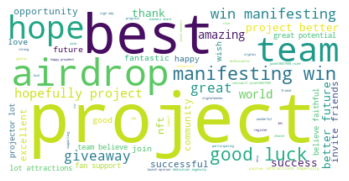

In [338]:
ada_samples = get_samples(ada_data)
ada_samples['positive sample'] = " ".join(sample for sample in ada_samples['positive sample'])
ada_samples['negative sample'] = " ".join(sample for sample in ada_samples['negative sample'])

ada_pos_wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(ada_samples['positive sample'])
plt.imshow(ada_pos_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

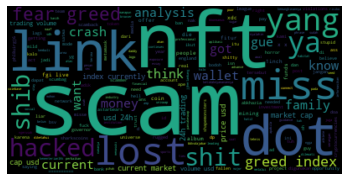

In [339]:
ada_neg_wordcloud = WordCloud(stopwords=stopwords).generate(ada_samples['negative sample'])
plt.imshow(ada_neg_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [303]:
doge_tweets = tweets('2022-04-05', '2022-04-11', 100, 'doge OR dogecoin OR crypto -is:retweet lang:en')
doge_data = build_sentiment_df(doge_tweets, 'tweet')
doge_data.head()

,tweets,cleaned_tweets,textblob_subjectivity,nltk_polarity
0,"@spacemarvelinc hopefully, this project is a s...",spacemarvelinc hopefully project success best ...,0.41,0.9705
1,@crypto_bearr @rkropachek done https://t.co/3m...,crypto bearr rkropachek https t 3mcaeips4y,0.00,0.0000
2,rt @themooncarl: #dogecoin surged after elon m...,rt themooncarl dogecoin surged elon musk acqui...,0.00,0.0000
3,i believe each $xrp is worth $589 #ripple #cry...,believe xrp worth 589 ripple crypto https t ju...,0.10,0.2263
4,@warriorliongame @metasourcegames thank you fo...,warriorliongame metasourcegames thank providin...,0.00,0.6249


In [304]:
doge_emoji = group_emojis(sorted(get_emoji_count(doge_data).items(), key=lambda x: x[1], reverse=True))
doge_emoji 

C:\Users\gunin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  import sys
C:\Users\gunin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if __name__ == '__main__':


([('💎', 563), ('💠', 238), ('👉', 236), ('📢', 199), ('💚', 179)],
 [('🔥', 1390), ('💥', 356), ('👇', 298), ('💰', 233), ('🐕', 224)],
 [('📌', 55), ('😭', 26), ('🐑', 14), ('👺', 8), ('💴', 8)])

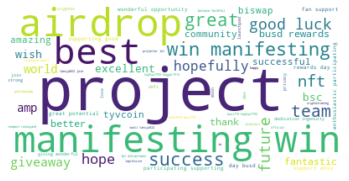

In [340]:
doge_samples = get_samples(doge_data)
doge_samples['positive sample'] = " ".join(sample for sample in doge_samples['positive sample'])
doge_samples['negative sample'] = " ".join(sample for sample in doge_samples['negative sample'])

doge_pos_wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(doge_samples['positive sample'])
plt.imshow(doge_pos_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

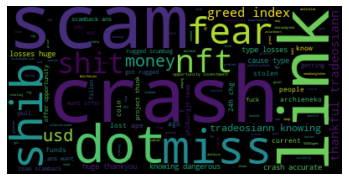

In [341]:
doge_neg_wordcloud = WordCloud(stopwords=stopwords).generate(doge_samples['negative sample'])
plt.imshow(doge_neg_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [315]:
amc_tweets = tweets('2022-04-05', '2022-04-11', 100, 'amc OR amc entertainment holdings -is:retweet lang:en')
amc_data = build_sentiment_df(amc_tweets, 'tweet')
amc_data.head()

,tweets,cleaned_tweets,textblob_subjectivity,nltk_polarity
0,$amc 🧀🧀 ️ https://t.co/zt1x9bxxwf,amc https t zt1x9bxxwf,0.0,0.0000
1,rt @potato_inmyass: fuck gary gensler $gme $amc,rt potato inmyass fuck gary gensler gme amc,0.6,-0.5423
2,rt @lahistoriaec: saltándose los requisitos. l...,rt lahistoriaec salt ndose los requisitos la d...,0.0,0.0000
3,@trialsearch i think this might comin in handy...,trialsearch think comin handy guys pun intende...,0.9,0.4019
4,rt @stonksarelife: hey @elonmusk how about buy...,rt stonksarelife hey elonmusk buying rest amc ...,0.9,0.0000


In [316]:
amc_emoji = group_emojis(sorted(get_emoji_count(amc_data).items(), key=lambda x: x[1], reverse=True))
amc_emoji 

C:\Users\gunin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  import sys
C:\Users\gunin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if __name__ == '__main__':


([('💎', 149), ('💕', 125), ('🌐', 71), ('🍿', 70), ('💪', 61)],
 [('🔥', 498), ('😂', 189), ('👀', 91), ('🎩', 81), ('👇', 69)],
 [('😭', 37), ('📌', 17), ('💀', 13), ('😡', 7), ('💩', 6)])

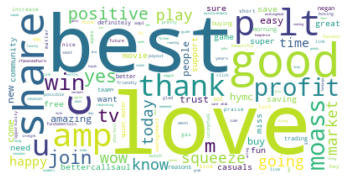

In [342]:
amc_samples = get_samples(amc_data)
amc_samples['positive sample'] = " ".join(sample for sample in amc_samples['positive sample'])
amc_samples['negative sample'] = " ".join(sample for sample in amc_samples['negative sample'])

amc_pos_wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(amc_samples['positive sample'])
plt.imshow(amc_pos_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

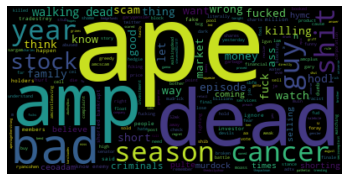

In [343]:
amc_neg_wordcloud = WordCloud(stopwords=stopwords).generate(amc_samples['negative sample'])
plt.imshow(amc_neg_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [322]:
tsla_tweets = tweets('2022-04-05', '2022-04-11', 100, 'tsla OR tesla -is:retweet lang:en')
tsla_data = build_sentiment_df(tsla_tweets, 'tweet')
tsla_data.head()

,tweets,cleaned_tweets,textblob_subjectivity,nltk_polarity
0,@gyrowavegen_tm @philipcockram1 @tesla usa is ...,gyrowavegen tm philipcockram1 tesla usa broke ...,0.000000,-0.4215
1,@hrhcollection @tesla @elonmusk i love your g ...,hrhcollection tesla elonmusk love g wagon perf...,0.800000,0.8360
2,rt @stonksarelife: hey @elonmusk how about buy...,rt stonksarelife hey elonmusk buying rest amc ...,0.900000,0.0000
3,@hawttoys @elonmusk on reflection: he's had th...,hawttoys elonmusk reflection s planned sold te...,0.100000,0.0000
4,@ow_sbinotto @engineers_feed @stats_feed why w...,ow sbinotto engineers feed stats feed happen t...,0.666667,-0.5574


In [324]:
tsla_emoji = group_emojis(sorted(get_emoji_count(tsla_data).items(), key=lambda x: x[1], reverse=True))
tsla_emoji 

C:\Users\gunin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  import sys
C:\Users\gunin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if __name__ == '__main__':


([('👉', 93), ('💎', 87), ('😎', 74), ('📈', 69), ('👍', 58)],
 [('👇', 209), ('🔥', 164), ('😂', 163), ('💯', 87), ('👀', 55)],
 [('😭', 20), ('🔋', 16), ('😡', 6), ('💀', 5), ('📌', 5)])

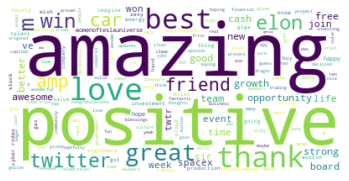

In [344]:
tsla_samples = get_samples(tsla_data)
tsla_samples['positive sample'] = " ".join(sample for sample in tsla_samples['positive sample'])
tsla_samples['negative sample'] = " ".join(sample for sample in tsla_samples['negative sample'])

tsla_pos_wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(tsla_samples['positive sample'])
plt.imshow(tsla_pos_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

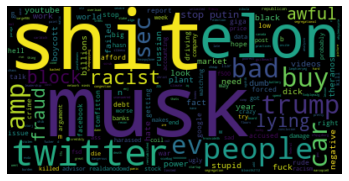

In [348]:
tsla_neg_wordcloud = WordCloud(stopwords=stopwords).generate(tsla_samples['negative sample'])
plt.imshow(tsla_neg_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [323]:
gme_tweets = tweets('2022-04-05', '2022-04-11', 100, 'gme OR gamestop OR gamestonk -is:retweet lang:en')
gme_data = build_sentiment_df(gme_tweets, 'tweet')
gme_data.head()

,tweets,cleaned_tweets,textblob_subjectivity,nltk_polarity
0,@antonku62463911 @gme_gun @dealovakikin_ @arya...,antonku62463911 gme gun dealovakikin arya dipa...,0.0,-0.3400
1,rt @j_mo52: zero shares available to borrow on...,rt j mo52 zero shares available borrow gme 100...,0.4,0.5267
2,@spikechunsoft_e @gamestop steam?,spikechunsoft e gamestop steam,0.0,0.0000
3,"🌊🌊🌊 weekly trade ideas: #spy entry: $448, pt: ...",weekly trade ideas spy entry 448 pt 470 qqq cu...,0.6,0.2500
4,@antonku62463911 @_seknas_ri @gme_gun @arya_di...,antonku62463911 seknas ri gme gun arya dipa45 ...,0.0,-0.3400


In [331]:
gme_emoji = group_emojis(sorted(get_emoji_count(gme_data).items(), key=lambda x: x[1], reverse=True))
gme_emoji 

C:\Users\gunin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  import sys
C:\Users\gunin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if __name__ == '__main__':


([('💎', 71), ('🙏', 55), ('📈', 35), ('💪', 32), ('🏴', 31)],
 [('🔥', 179), ('😂', 144), ('👀', 94), ('💰', 55), ('👇', 47)],
 [('😭', 32), ('💀', 24), ('💩', 21), ('🔨', 8), ('😒', 6)])

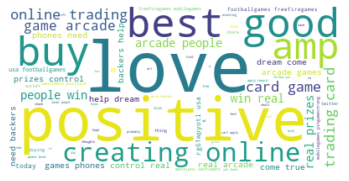

In [349]:
gme_samples = get_samples(gme_data)
gme_samples['positive sample'] = " ".join(sample for sample in gme_samples['positive sample'])
gme_samples['negative sample'] = " ".join(sample for sample in gme_samples['negative sample'])

gme_pos_wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(gme_samples['positive sample'])
plt.imshow(gme_pos_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

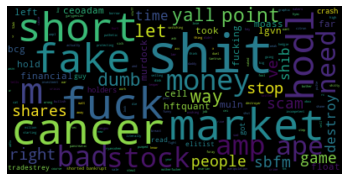

In [335]:
gme_neg_wordcloud = WordCloud(stopwords=stopwords).generate(gme_samples['negative sample'])
plt.imshow(gme_neg_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# emoji graphs

In [373]:
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import matplotlib.pyplot as plt 

# gathering data
btc_ge1 = btc_emoji[0]
btc_ge2 = btc_emoji[1]
btc_ge3 = btc_emoji[2]

btc_pos_sample_df = pd.DataFrame(btc_ge1)
btc_neut_sample_df = pd.DataFrame(btc_ge2)
btc_neg_sample_df = pd.DataFrame(btc_ge3)

btc_pos_sum = btc_pos_sample_df[1].sum()
btc_neutral_sum = btc_neut_sample_df[1].sum()
btc_neg_sum = btc_neg_sample_df[1].sum() 

btc_emoji_summary = {'pos_count': btc_pos_sum, 'neut_count': btc_neutral_sum, 'neg_count': btc_neg_sum}


eth_ge1 = eth_emoji[0]
eth_ge2 = eth_emoji[1]
eth_ge3 = eth_emoji[2]

eth_pos_sample_df = pd.DataFrame(eth_ge1)
eth_neut_sample_df = pd.DataFrame(eth_ge2)
eth_neg_sample_df = pd.DataFrame(eth_ge3)

eth_pos_sum = eth_pos_sample_df[1].sum()
eth_neutral_sum = eth_neut_sample_df[1].sum()
eth_neg_sum = eth_neg_sample_df[1].sum() 

eth_emoji_summary = {'pos_count': eth_pos_sum, 'neut_count': eth_neutral_sum, 'neg_count': eth_neg_sum}


ada_ge1 = ada_emoji[0]
ada_ge2 = ada_emoji[1]
ada_ge3 = ada_emoji[2]

ada_pos_sample_df = pd.DataFrame(ada_ge1)
ada_neut_sample_df = pd.DataFrame(ada_ge2)
ada_neg_sample_df = pd.DataFrame(ada_ge3)

ada_pos_sum = ada_pos_sample_df[1].sum()
ada_neutral_sum = ada_neut_sample_df[1].sum()
ada_neg_sum = ada_neg_sample_df[1].sum() 

ada_emoji_summary = {'pos_count': ada_pos_sum, 'neut_count': ada_neutral_sum, 'neg_count': ada_neg_sum}


doge_ge1 = doge_emoji[0]
doge_ge2 = doge_emoji[1]
doge_ge3 = doge_emoji[2]

doge_pos_sample_df = pd.DataFrame(doge_ge1)
doge_neut_sample_df = pd.DataFrame(doge_ge2)
doge_neg_sample_df = pd.DataFrame(doge_ge3)

doge_pos_sum = doge_pos_sample_df[1].sum()
doge_neutral_sum = doge_neut_sample_df[1].sum()
doge_neg_sum = doge_neg_sample_df[1].sum() 

doge_emoji_summary = {'pos_count': doge_pos_sum, 'neut_count': doge_neutral_sum, 'neg_count': doge_neg_sum}


amc_ge1 = amc_emoji[0]
amc_ge2 = amc_emoji[1]
amc_ge3 = amc_emoji[2]

amc_pos_sample_df = pd.DataFrame(amc_ge1)
amc_neut_sample_df = pd.DataFrame(amc_ge2)
amc_neg_sample_df = pd.DataFrame(amc_ge3)

amc_pos_sum = amc_pos_sample_df[1].sum()
amc_neutral_sum = amc_neut_sample_df[1].sum()
amc_neg_sum = amc_neg_sample_df[1].sum() 

amc_emoji_summary = {'pos_count': amc_pos_sum, 'neut_count': amc_neutral_sum, 'neg_count': amc_neg_sum}


tsla_ge1 = tsla_emoji[0]
tsla_ge2 = tsla_emoji[1]
tsla_ge3 = tsla_emoji[2]

tsla_pos_sample_df = pd.DataFrame(tsla_ge1)
tsla_neut_sample_df = pd.DataFrame(tsla_ge2)
tsla_neg_sample_df = pd.DataFrame(tsla_ge3)

tsla_pos_sum = tsla_pos_sample_df[1].sum()
tsla_neutral_sum = tsla_neut_sample_df[1].sum()
tsla_neg_sum = tsla_neg_sample_df[1].sum() 

tsla_emoji_summary = {'pos_count': tsla_pos_sum, 'neut_count': tsla_neutral_sum, 'neg_count': tsla_neg_sum}


gme_ge1 = gme_emoji[0]
gme_ge2 = gme_emoji[1]
gme_ge3 = gme_emoji[2]

gme_pos_sample_df = pd.DataFrame(gme_ge1)
gme_neut_sample_df = pd.DataFrame(gme_ge2)
gme_neg_sample_df = pd.DataFrame(gme_ge3)

gme_pos_sum = gme_pos_sample_df[1].sum()
gme_neutral_sum = gme_neut_sample_df[1].sum()
gme_neg_sum = gme_neg_sample_df[1].sum() 

gme_emoji_summary = {'pos_count': gme_pos_sum, 'neut_count': gme_neutral_sum, 'neg_count': gme_neg_sum}




In [376]:
emoji_summaries = {'btc': btc_emoji_summary, 'eth': eth_emoji_summary, 'ada': ada_emoji_summary, 'doge': doge_emoji_summary, 'amc': amc_emoji_summary, 'tsla': tsla_emoji_summary, 'gme': gme_emoji_summary}
emoji_summaries

{'btc': {'pos_count': 745, 'neut_count': 1774, 'neg_count': 163},
 'eth': {'pos_count': 2138, 'neut_count': 1818, 'neg_count': 291},
 'ada': {'pos_count': 609, 'neut_count': 984, 'neg_count': 522},
 'doge': {'pos_count': 1415, 'neut_count': 2501, 'neg_count': 111},
 'amc': {'pos_count': 476, 'neut_count': 928, 'neg_count': 80},
 'tsla': {'pos_count': 381, 'neut_count': 678, 'neg_count': 52},
 'gme': {'pos_count': 224, 'neut_count': 519, 'neg_count': 91}}

In [362]:
doge_data.head()

,tweets,cleaned_tweets,textblob_subjectivity,nltk_polarity
0,"@spacemarvelinc hopefully, this project is a s...",spacemarvelinc hopefully project success best ...,0.41,0.9705
1,@crypto_bearr @rkropachek done https://t.co/3m...,crypto bearr rkropachek https t 3mcaeips4y,0.00,0.0000
2,rt @themooncarl: #dogecoin surged after elon m...,rt themooncarl dogecoin surged elon musk acqui...,0.00,0.0000
3,i believe each $xrp is worth $589 #ripple #cry...,believe xrp worth 589 ripple crypto https t ju...,0.10,0.2263
4,@warriorliongame @metasourcegames thank you fo...,warriorliongame metasourcegames thank providin...,0.00,0.6249


In [363]:
doge_data.corr()

,textblob_subjectivity,nltk_polarity
textblob_subjectivity,1.0000,0.4488
nltk_polarity,0.4488,1.0000


In [365]:
doge_data_path = Path("doge.csv")
doge_data_df = pd.read_csv(doge_data_path, skiprows=1)
doge_data_df.head()

,Date Time,Open,High,Low,Close,Change,Volume,Open Interest
0,4/04/2022 0:00,0.14506,0.14588,0.14502,0.14510,0.00004,390.0,NaN
1,4/04/2022 1:00,0.14510,0.14510,0.14452,0.14487,-0.00023,392.0,NaN
2,4/04/2022 2:00,0.14487,0.14487,0.14387,0.14401,-0.00086,368.0,NaN
3,4/04/2022 3:00,0.14401,0.14437,0.14337,0.14416,0.00015,378.0,NaN
4,4/04/2022 4:00,0.14416,0.14416,0.14218,0.14222,-0.00194,379.0,NaN


In [366]:
doge_combined = pd.concat([doge_data, doge_data_df['Change']], axis='columns', join='inner')

In [367]:
doge_combined.corr()

,textblob_subjectivity,nltk_polarity,Change
textblob_subjectivity,1.000000,0.60590,-0.026842
nltk_polarity,0.605900,1.00000,-0.005090
Change,-0.026842,-0.00509,1.000000


<AxesSubplot:xlabel='nltk_polarity', ylabel='Change'>

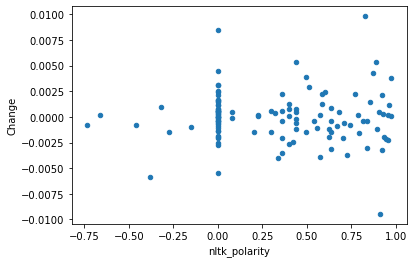

In [370]:
doge_combined.plot.scatter('nltk_polarity', 'Change')

In [377]:
emoji_summary_df = pd.DataFrame(emoji_summaries)

In [378]:
emoji_summary_df

,btc,eth,ada,doge,amc,tsla,gme
pos_count,745,2138,609,1415,476,381,224
neut_count,1774,1818,984,2501,928,678,519
neg_count,163,291,522,111,80,52,91


In [380]:
# emoji counts
emoji_summary_df.hvplot.bar()

:Bars   [index,Variable]   (value)